<a href="https://colab.research.google.com/github/lab4isc/ECEN4303_Project-Description-Fall-21-/blob/main/mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#MLP Neural Network

##Background

###Multi-Layer Perceptrons
What is a MLP? A multi-layer perceptron is a feedforward artificial neural network that generates a set of outputs from a set of inputs. Neural Networks are generally created by creating layers of nodes called neurons that will perform some function given data. MLPs consist of at least three layers of nodes: an input layer, an output layer, and one or more hidden layers. 

In this tutorial, we will introduce a use case of MLP to recognize the handwritten digits (i.e., 0 - 9). The dataset uses the MNIST. For this case, the inputs of MLP will be the handwritten digit images (e.g., an image of digit 1) and the ten outputs indicate the probabilities of ten digits of the input image. The largest output indicates the digit value of the input image.

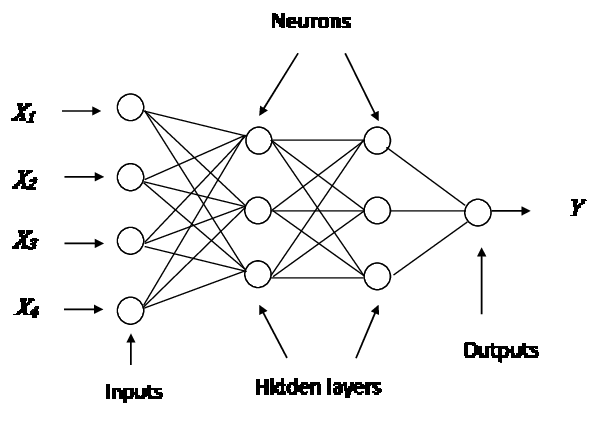

Each neuron is ran through a training process in order for them to "learn" appropriate functions for correct guesses. Learning occurs in the perceptron by changing connection weights after all data provided in a training batch is processed, based on the amount of error in the output compared to the expected result. This process is called supervised learning and is carried out through backpropogation of the neural network.

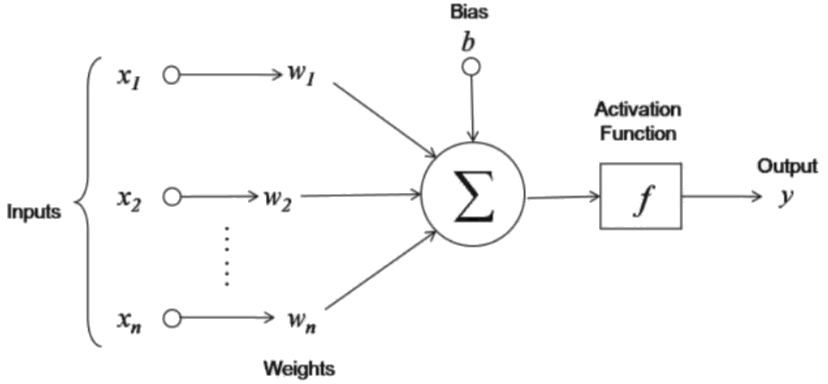

Above is the simplified function at any given neuron, an input (x) is received it is multiplied by some weight (w) that is held in the neuron. This is done on all incoming inputs, where they will be summed up, have a bias (b) added to them, then finally at the output of the neuron a non-linear activation function (f) will be used such as the [relu](https://en.wikipedia.org/wiki/Rectifier_(neural_networks)) function and or the [softmax](https://en.wikipedia.org/wiki/Softmax_function) function.

For the purposes of this tutorial pytorch will be used

In [ ]:
# import libraries
import torch
import numpy as np

##Load and Visulize the Data


###Load
Code for processing data samples can get messy and hard to maintain; we ideally want our dataset code to be decoupled from our model training code for better readability and modularity. PyTorch provides two data primitives: 
```
torch.utils.data.DataLoader
torch.utils.data.Dataset
```
that allow you to use pre-loaded datasets as well as your own data. Dataset stores the samples and their corresponding labels, and DataLoader wraps an iterable around the Dataset to enable easy access to the samples.

For this example the [MNIST](https://en.wikipedia.org/wiki/MNIST_database) dataset set will be used. In the cell below the training dataset and testing datasets are downloaded and stored into train_data and test_data. Train_data will contain 60,000 training images and labels while test_data will contain 10,000.

From there they will be loaded into their respective data loaders split into the batch size specified by the user.

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)
test_data = datasets.MNIST(root='data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
    num_workers=num_workers)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


###Visualize
This cell will print out the first batch of data contained in the training set. This is an important step first to check and see if the data is loaded correctly and to check for any initial observations about data patterns

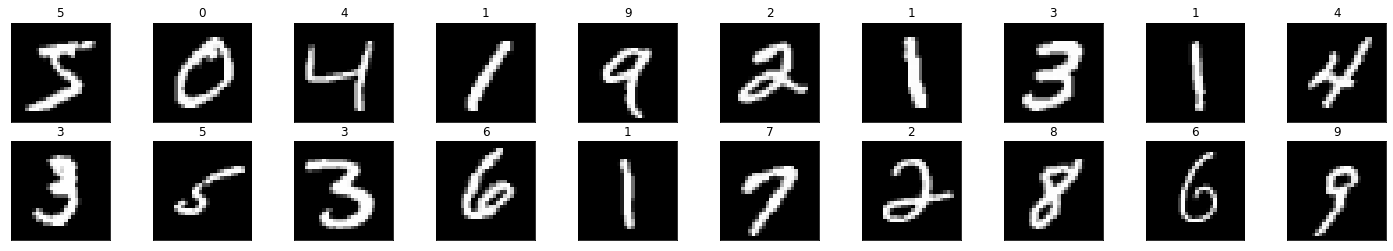

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
    
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    # print out the correct label for each image
    # .item() gets the value contained in a Tensor
    ax.set_title(str(labels[idx].item()))

Next step in visualization is to observe how your data will be represented to the Neural Network in this case images will be converted into a 28x28 greyscale image, whose pixels will be assigned a floating point value between 0 and 1 point value with 0 being black and 1.0 being white.

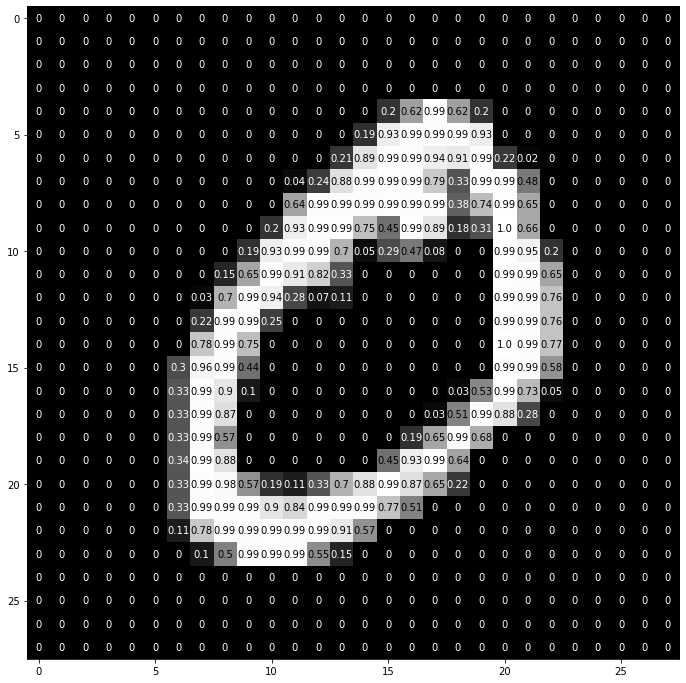

In [ ]:
img = np.squeeze(images[1])

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
ax.imshow(img, cmap='gray')
width, height = img.shape
thresh = img.max()/2.5
for x in range(width):
    for y in range(height):
        val = round(img[x][y],2) if img[x][y] !=0 else 0
        ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center',
                    color='white' if img[x][y]<thresh else 'black')

##Defining the Neural Network


To define your Neural Network you will need to subclass the ```nn.Module``` and initialize the network layers in  ```__init__``` and all input data should be implemented in the ```forward``` function.

###Layer Selection
There are several types of layers that can be used but for this case a simple linear transformation is all that is required to implement hidden and output layers. The parameters required for declaring a linear layers are as follows:
```nn.Linear(in_feats, out_feats)```. Where ```in_feats``` is the number of inputs into each neuron, and ```out_feats``` is the number of neurons per layer. Linear layers aim to train the following equation:

$$
\mathbf{y} = {x}{W}^{T}+{b}
$$

To implement these layers we declare them in the __init__ function of our NeuralNet class. This is mearly a declaration so W and b will be some completely random value until they are trained. 

###Forward Pass
Another function that needs to be implemented in our NeuralNet class is the forward pass function, simply put, this function needs to handle passing data between the different layers as well as handling all activation functions that you have chosen to use on your data.

###Model Code

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary

## Define the NN architecture
class NeuralNet(nn.Module):
    def __init__(self):
        super(NeuralNet, self).__init__()
        # linear layer 28*28 input into 16 nodes
        self.fc1 = nn.Linear(28 * 28, 16)

        # linear layer (n_hidden -> 10)
        self.fc2 = nn.Linear(16, 10)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))

        x = self.fc2(x)

        return x

# initialize the NN
model = NeuralNet()
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]          12,560
            Linear-2                   [-1, 10]             170
Total params: 12,730
Trainable params: 12,730
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.05
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


##Training

The next step in the process is now training the neural network. This process involves many forward and backward passes through the network called epochs. During an epoch the training data image will be passed into the neural network where an output will be produced in the form of a probability matrix. The neural network will use the error that has occured from the guess and attempt to 'learn', this process is the backwards pass.

During the forward pass, data is simply fed through the network and an output is received where an error, or loss, will be calculated based on the outputs of the training data. This is where backpropagation begins.

Backpropagation aims to adjust the weights of the connections in the network to minimize the difference between the predicted output vector and the desired output vector. This difference is represented by the 'Loss' of the neural network. Your overall goal is to choose is to decrease your loss as much as possible there are several algorithms such as [MSE](https://pytorch.org/docs/stable/generated/torch.nn.L1Loss.html#torch.nn.L1Loss) and [MAE](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html#torch.nn.MSELoss) used to minimize loss. For this case you will be using the [CrossEntropy](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss) Loss function, more information as per why can be found [here](https://machinelearningmastery.com/how-to-choose-loss-functions-when-training-deep-learning-neural-networks/), but the summary is since we are aiming to optimize a classification predictive model we want to heavily penalize incorrect guesses

Here criterion is used to specify a loss function provided by pytorch for convience [here](https://pytorch.org/docs/stable/nn.html#loss-functions).

Optimizer is chosen from [here](https://pytorch.org/docs/stable/optim.html)

In [ ]:
## Specify loss and optimization functions

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# number of epochs to train the model
n_epochs = 5  # suggest training between 20-50 epochs

# Set model to the training mode
model.train()

for epoch in range(n_epochs):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for data, target in train_loader:
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)

        # calculate the loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update running training loss
        train_loss += loss.item()*data.size(0)
        
    # print training statistics 
    # calculate average loss over an epoch
    train_loss = train_loss/len(train_loader.dataset)

    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch+1, 
        train_loss
        ))

Epoch: 1 	Training Loss: 0.758434
Epoch: 2 	Training Loss: 0.349796
Epoch: 3 	Training Loss: 0.307162
Epoch: 4 	Training Loss: 0.283784
Epoch: 5 	Training Loss: 0.267246


##Evalution

The purpose of this section is to evaluate your model based on the data provided
in the testing set. Here your model will be switched to evaluation mode where 
forward passes will be performed and a predicted value will be returned.

In [ ]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# Set model to evaluation mode
model.eval()

for data, target in test_loader:
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        try:
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1
        except IndexError:
          break

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.258970

Test Accuracy of     0: 98% (965/980)
Test Accuracy of     1: 98% (1117/1135)
Test Accuracy of     2: 88% (909/1032)
Test Accuracy of     3: 91% (925/1010)
Test Accuracy of     4: 91% (900/982)
Test Accuracy of     5: 90% (806/892)
Test Accuracy of     6: 93% (899/958)
Test Accuracy of     7: 92% (946/1028)
Test Accuracy of     8: 87% (854/974)
Test Accuracy of     9: 93% (939/1009)

Test Accuracy (Overall): 92% (9260/10000)


Above is the overall accuracy of your Network if your accuracy is poor here you will have a bad time when testing it on real world examples. So it highly suggested that you play with the training time by changing the number of epochs that are allowed to happen. As well as playing with the batch size of the training inputs

###Visual Evaluation

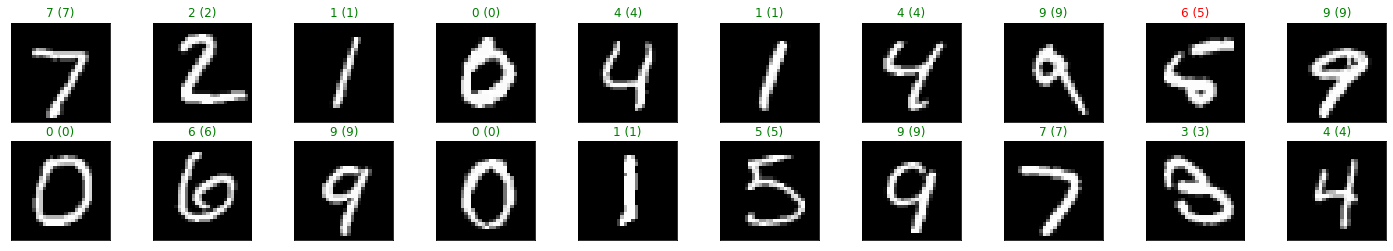

In [ ]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(2, batch_size/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))

# Guide of what you need to do
In this tutorial, we have done pretty much all of the coding parts for MLP training part. The followings are the things that you need to do by yourself for this phase project.

1. You will need to adjust the size and training times of the Neural Network in order to match the designated neuron and accuracy constraints of the project
2. After training your neural network model, you will need to figure out how to store it so that it can be accessed later.
3. You need to extract the weights and biases from your trained model, these items will be saved in a file and then loaded into memory in your hardware design. 



# Expected Outcomes

1.   Construction of a software Classification model that can accurately identify data from the MNIST dataset
2.   Test your model over more data and provide the comparison between classified results and its label 
3. Just keep in mind: the classificatin model will be used for the hardware implementation.


# Extra Resources
1.   Simple explaination on Neural Networks: https://www.youtube.com/watch?v=aircAruvnKk
2.   Introduction to Deep Learning with Python: https://pythonprogramming.net/introduction-deep-learning-neural-network-pytorch/

